In [1]:
include("../../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack
using Plots
using OrdinaryDiffEq

In [3]:
# Parameters
grid_resolution        = 100
quadrature_order       = 5
nevs                   = 10        # which Eigenvector to choose
num_steps              = 200
ϵ                      = 2
t₀                      = 0.6      # parameter value corresponding to ϵ=0
wind_scale             = 1e-3
wind_center            = 0
solver_tolerance       = 1e-5
solver                 = OrdinaryDiffEq.BS5();

In [4]:
rot_double_gyre = @velo_from_stream Ψ_rot_dgyre begin
    st          = heaviside(t)*heaviside(1-t)*t^2*(3-2*t) + heaviside(t-1)
    heaviside(x)= 0.5*(sign(x) + 1)
    Ψ_P         = sin(2π*x)*sin(π*y)
    Ψ_F         = sin(π*x)*sin(2π*y)
    Ψ_rot_dgyre = (1-st) * Ψ_P + st * Ψ_F
end
nothing

In [5]:
gyre_wind(param) = OrdinaryDiffEq.ODEFunction{false}((u,p,t) -> rot_double_gyre(u,p,t) + param*wind_scale*[u[2]-wind_center, 0]);

In [6]:
T(x,p) = flow(gyre_wind(p), x, [0.0, t₀],
    tolerance = solver_tolerance, solver = solver)[end];

In [7]:
LL, UR = (0.0, 0.0), (1.0, 1.0)
ctx, _ = regularTriangularGrid((grid_resolution, grid_resolution), LL, UR, quadrature_order = quadrature_order);

In [8]:
M = assembleMassMatrix(ctx);

In [9]:
# assemble K
DT₀(x) = linearized_flow_autodiff(y -> T(y,0) , x)
A₀(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DT₀(x))))
@time K = assembleStiffnessMatrix(ctx, A₀);

119.912821 seconds (895.41 M allocations: 39.170 GiB, 5.74% gc time)


In [10]:
evs = zeros(num_steps+1,nevs)
evs[Int(num_steps/2 +1),:] , _ = eigs(K, M, nev=nevs, which=:SM);

In [11]:
for i in 1:(num_steps/2)
    DTϵ(x) = linearized_flow_autodiff(y -> T(y,i*ϵ) , x)
    Aϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTϵ(x))))
    @time Kϵ = assembleStiffnessMatrix(ctx, Aϵ)
    DTminusϵ(x) = linearized_flow_autodiff(y -> T(y,-i*ϵ) , x)
    Aminusϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTminusϵ(x))))
    @time Kminusϵ = assembleStiffnessMatrix(ctx, Aminusϵ)
    evs[Int(num_steps/2 +1+i),:], _ = eigs(Kϵ, M, nev=nevs, which=:SM)
    evs[Int(num_steps/2 +1-i),:], _ = eigs(Kminusϵ, M, nev=nevs, which=:SM)
    print(Int(i), "/" ,Int(num_steps/2), "\n")
end
nothing

114.547206 seconds (880.38 M allocations: 37.436 GiB, 5.73% gc time)
113.572488 seconds (878.58 M allocations: 37.332 GiB, 5.54% gc time)
1/100
109.478227 seconds (871.81 M allocations: 37.001 GiB, 5.67% gc time)
111.993911 seconds (871.50 M allocations: 36.988 GiB, 5.51% gc time)
2/100
109.776607 seconds (871.85 M allocations: 37.003 GiB, 5.54% gc time)
111.310436 seconds (871.43 M allocations: 36.985 GiB, 5.46% gc time)
3/100
109.744840 seconds (871.92 M allocations: 37.006 GiB, 5.50% gc time)
111.617880 seconds (871.34 M allocations: 36.981 GiB, 5.36% gc time)
4/100
109.713057 seconds (871.99 M allocations: 37.008 GiB, 5.46% gc time)
111.585480 seconds (871.26 M allocations: 36.978 GiB, 5.37% gc time)
5/100
109.191567 seconds (872.06 M allocations: 37.011 GiB, 5.37% gc time)
110.886217 seconds (871.20 M allocations: 36.975 GiB, 5.28% gc time)
6/100
 95.116841 seconds (872.13 M allocations: 37.014 GiB, 3.97% gc time)
 95.547220 seconds (871.16 M allocations: 36.973 GiB, 3.50% gc time

57/100
 99.903602 seconds (874.92 M allocations: 37.131 GiB, 3.46% gc time)
 99.331589 seconds (868.41 M allocations: 36.858 GiB, 3.43% gc time)
58/100
 97.376082 seconds (874.96 M allocations: 37.133 GiB, 3.53% gc time)
 97.926223 seconds (868.37 M allocations: 36.856 GiB, 3.49% gc time)
59/100
100.689799 seconds (875.01 M allocations: 37.135 GiB, 3.59% gc time)
100.551396 seconds (868.31 M allocations: 36.854 GiB, 3.45% gc time)
60/100
100.417928 seconds (875.07 M allocations: 37.138 GiB, 3.50% gc time)
102.445754 seconds (868.27 M allocations: 36.852 GiB, 3.56% gc time)
61/100
 95.420926 seconds (875.11 M allocations: 37.140 GiB, 4.06% gc time)
 96.117648 seconds (868.21 M allocations: 36.849 GiB, 3.72% gc time)
62/100
 96.151381 seconds (875.15 M allocations: 37.141 GiB, 3.64% gc time)
 97.217595 seconds (868.17 M allocations: 36.848 GiB, 3.53% gc time)
63/100
 97.223291 seconds (875.19 M allocations: 37.143 GiB, 3.52% gc time)
 96.634206 seconds (868.13 M allocations: 36.846 GiB, 

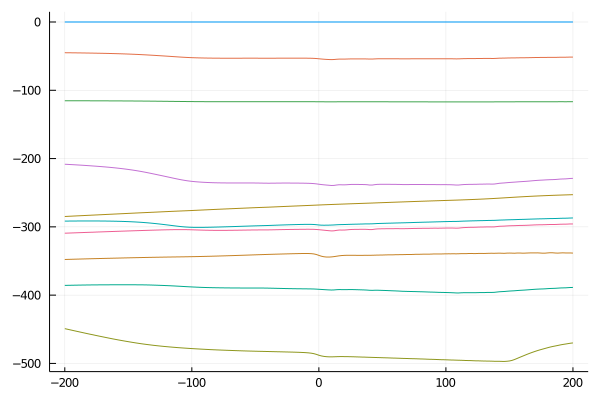

In [12]:
Plots.plot(range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1), evs, legend=false, fmt = :png)

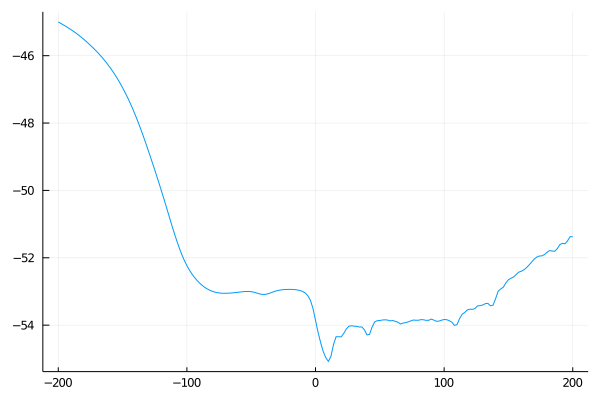

In [13]:
Plots.plot(range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1), evs[:,2], legend=false, fmt = :png)

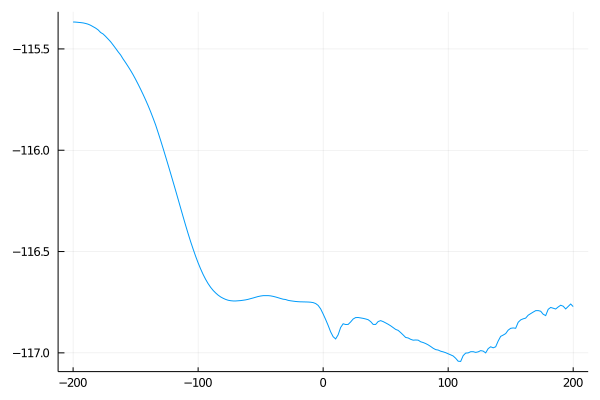

In [14]:
Plots.plot(range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1), evs[:,3], legend=false, fmt = :png)

In [15]:
using DelimitedFiles

In [16]:
writedlm("D:/gyre_wind_eigenvalues_n="*string(grid_resolution)*"_tol="*string(solver_tolerance)*
        "_qo="*string(quadrature_order)*"_solver="*string(solver)*"_method=CG.csv",
        [range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1)  evs], ",")